In [1]:
import csv
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from collections import Counter

from sklearn.model_selection import train_test_split
from collections import defaultdict

from PIL import Image
import math
from random import shuffle

from keras.models import Sequential, Model
from keras.layers import Input, Convolution2D, Flatten, Dense, Dropout, Activation, Lambda, Cropping2D


path2data = '/home/kputtur/Desktop/simulator'

def plot_histogram(lines):
    steering_angle = []
    for line in lines:
            steering_angle.append(round(float(line[3]), 1))
            
    labels, values = zip(*Counter(steering_angle).items())
    
    print(labels)
    print(values)
    
    fig, ax = plt.subplots(figsize=(15, 10))
    
    plt.bar(list(labels), list(values), width=0.2, color='g', linewidth=0)
            
    plt.xlabel('Angles')
    plt.ylabel('Frequency(counts)')
    plt.title(r'$\mathrm{Histogram\ of\ Cameras\ Angles:}\ \mu=0, \ \sigma=0.1$')
    plt.axis([-2, 2, 0, 6000])
    plt.grid(True)
    plt.show()
    
def show_img_3(images, image_titles=[]):
    plt.figure(figsize=(12, 12))
    for i in range(0,3):
        plt.subplot(1, 3, i+1)
        plt.imshow(images[i])
        plt.title(image_titles[i])
    plt.show()

def load_csv_file(path):
        lines = []
        dirs = os.listdir(path)
        for file in dirs:
                dirname = os.path.join(path, file)
                filename = os.path.join(dirname, 'driving_log.csv')
                try:
                        with open(filename, 'r') as csvfile:
                                reader = csv.reader(csvfile)
                                for row in reader:
                                        lines.append(row)
                except IOError:
                        print("some error occured")
                        raise

        return lines


Using TensorFlow backend.


In [2]:
def remove_zeros(lines):
        i = 0
        while i < len(lines):
                if abs(float(lines[i][3])) < PARAM['steer_angle_tolerance']:
                        #removing random values
                         if np.random.rand() < 0.95:
                                del lines[i]
                i += 1
        return lines 

In [3]:
def load_images_and_measurements(lines):
        car_images = []
        steering_angles  = []

        for row in lines:
                steering_center = float(row[3])

                #create adjusted steering measurements for the side camera images
                correction = 0.2
                steering_left = steering_center + correction
                steering_right = steering_center - correction


                img_center = np.asarray(Image.open(row[0]))
                img_left = np.asarray(Image.open(row[1]))
                img_right = np.asarray(Image.open(row[2]))

                car_images.extend([img_center, img_left, img_right])
                steering_angles.extend([steering_center, steering_left, steering_right])
        
        return car_images, steering_angles

In [4]:
def flip_image_steering(image, steering_angle):
        flipped_image = np.fliplr(image)
        flipped_steering_angle = steering_angle * -1.0
        return flipped_image, flipped_steering_angle


In [58]:
def augment_data (images, measurements):
        augmented_images, augmented_measurements = [], []

        for image, steering_angle in zip(images, measurements):
                flipped_image, flipped_steering_angle = flip_image_steering(image, steering_angle)
                flipped_image = cv2.cvtColor(flipped_image, cv2.COLOR_BGR2HSV)
                augmented_images.append(flipped_image)
                augmented_images.append(image)
                augmented_measurements.append(flipped_steering_angle)
                augmented_measurements.append(steering_angle)

        return augmented_images, augmented_measurements


In [6]:
def data_generator(samples, batch_size):
        print('data generator seeding ...')
        num_samples = len(samples)

        while 1:                #Starting the co-routine
                shuffle(samples)

                X_data = []
                y_data = []

                for i, line in enumerate(samples):
                        images, measurements = load_images_and_measurements([line])

                        #flip the image file
                        augmented_images, augmented_measurements = augment_data(images, measurements)

                        #Add the generated data into yeild array
                        X_data.extend(augmented_images)
                        y_data.extend(augmented_measurements)


                        #Check if i is equal to
                        if i == (num_samples - 1) or  len (X_data) > batch_size:
                                yield sklearn.utils.shuffle(np.array(X_data[:batch_size]), np.array(y_data[:batch_size]))
                                X_data[batch_size:]
                                y_data[batch_size:]


In [ ]:
def plot_loss(model_history):
    print(model_history,history.keys())
    plt.plot(model_history.history['loss'])
    plt.plot(model_history.history['val_loss'])
    plt.title('model mean squared error loss')
    plt.ylabel('mean squared error loss')
    plt.xlabel('epoch')
    plt.legend(['training set', 'validation set'], loc='upper right')
    plt.show()

In [7]:
def nvidia_model(summary=True):
        model = Sequential()
        model.add(Lambda(lambda x: x/255.0 - 0.5, input_shape=(PARAM['input_height'], PARAM['input_width'], PARAM['input_channels'])))
        model.add(Cropping2D(cropping=PARAM['cropping']))
        model.add(Convolution2D(24,5,5, subsample=(2,2), activation='relu'))
        model.add(Convolution2D(36,5,5, subsample=(2,2), activation='relu'))
        model.add(Convolution2D(48,5,5, subsample=(2,2), activation='relu'))
        model.add(Convolution2D(64,3,3, activation='relu'))
        model.add(Convolution2D(64,3,3, activation='relu'))
        model.add(Flatten())
        model.add(Dense(100, activation='relu'))
        model.add(Dropout(0.8) )
        model.add(Dense(50, activation='relu'))
        model.add(Dense(10, activation='relu'))
        model.add(Dense(1))

        if summary:
                model.summary()


        return model


In [ ]:
def LeNet_model(summary=True):                                                                                                                                                                              │
        model = Sequential()                                                                                                                                                                                │
        model.add(Lambda(lambda x: x/255.0 - 0.5, input_shape=(PARAM['input_height'], PARAM['input_width'], PARAM['input_channels'])))                                                                      │
        model.add(Cropping2D(cropping=PARAM['cropping']))                                                                                                                                                   │
        #MaxPooling 2D Layer                                                                                                                                                                                │
        model.add(MaxPooling2D())                                                                                                                                                                           │
        #Convlution Layer                                                                                                                                                                                   │
        model.add(Convolution2D(6,(5,5), activation='relu')                                                                                                                                                 │
        #Maxpooling 2D layer                                                                                                                                                                                │
        model.add(MaxPooling2D())                                                                                                                                                                           │
                                                                                                                                                                                                            │
        #Flatten                                                                                                                                                                                            │
        model.add(Flatten())                                                                                                                                                                                │
        #First Dense Layer                                                                                                                                                                                  │
        model.add(Dense(120))                                                                                                                                                                               │
        # Second Dense Layer                                                                                                                                                                                │
        model.add(Dense(84))                                                                                                                                                                                │
                                                                                                                                                                                                            │
        # Single Dense layer                                                                                                                                                                                │
        model.add(Dense(1))                                                                                                                                                                                 │
                                                                                                                                                                                                            │
                                                                                                                                                                                                            │
        if summary:                                                                                                                                                                                         │
                   model.summary()                                                                                                                                                                          │
                                                                                                                                                                                                            │
        return model                                                                                                                                                                                        │
                             

Total number of Samples 8099
(0.0, -0.2, 0.6, -0.4, 0.9, -0.5, 1.0, -0.8, -0.1, 0.1, -0.6, 0.7, 0.3, -1.0, -0.7, 0.4, -0.3, 0.2, 0.8, -0.9, 0.5)
(6004, 370, 29, 146, 5, 98, 2, 16, 441, 196, 72, 18, 130, 4, 36, 59, 276, 136, 15, 13, 33)


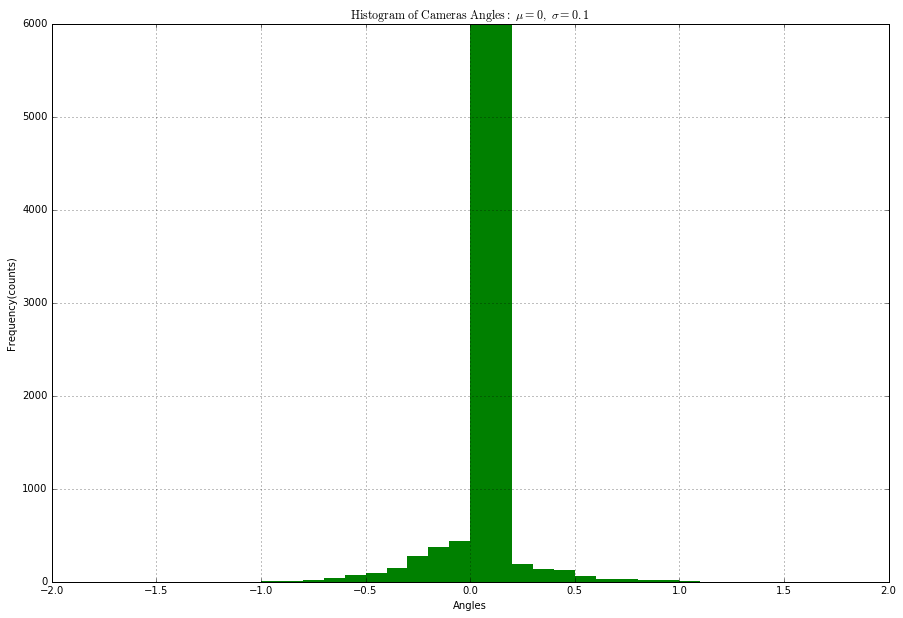

Total number of Samples 4967
(0.0, -0.2, 0.6, -0.4, 0.9, -0.5, 1.0, -0.8, -0.1, 0.1, -0.6, 0.7, 0.3, -1.0, -0.7, 0.4, -0.3, 0.2, 0.8, -0.9, 0.5)
(2991, 370, 29, 146, 5, 98, 2, 16, 365, 153, 72, 18, 130, 4, 36, 59, 276, 136, 15, 13, 33)


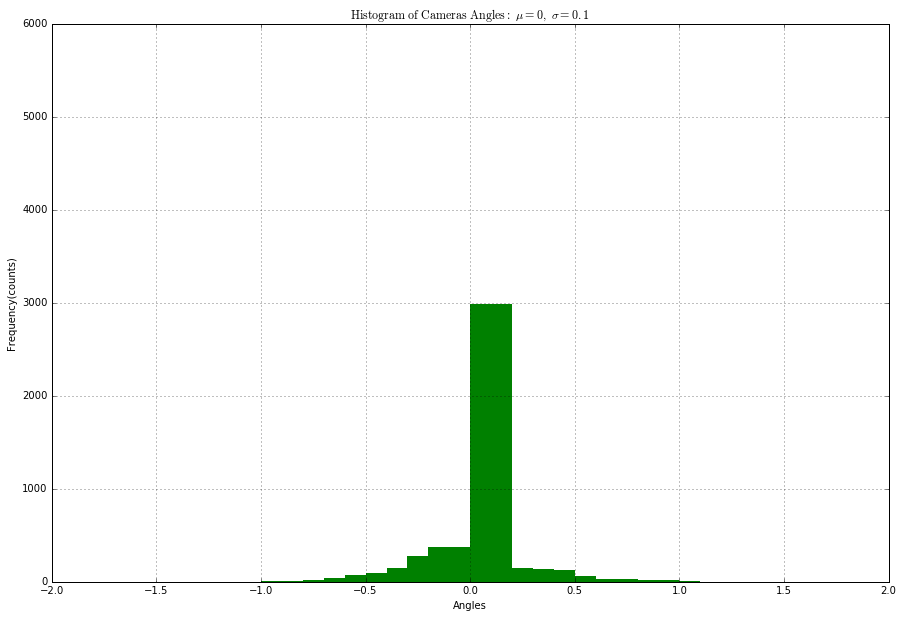

In [8]:
PARAM = {
'steer_angle_tolerance':0.08,   
'batchsize': 512,
'input_width': 320,
'input_height': 160,
'input_channels': 3,
'correction': 0.15,
'cropping': ((50,20), (0,0)),
'epoch' : 5
}

def plot_histogram(lines):
    steering_angle = []
    for line in lines:
            steering_angle.append(round(float(line[3]), 1))
            
    labels, values = zip(*Counter(steering_angle).items())
    
    print(labels)
    print(values)
    
    fig, ax = plt.subplots(figsize=(15, 10))
    
    plt.bar(list(labels), list(values), width=0.2, color='g', linewidth=0)
            
    plt.xlabel('Angles')
    plt.ylabel('Frequency(counts)')
    plt.title(r'$\mathrm{Histogram\ of\ Cameras\ Angles:}\ \mu=0, \ \sigma=0.1$')
    plt.axis([-2, 2, 0, 6000])
    plt.grid(True)
    plt.show()
    
lines = load_csv_file(path2data)

print('Total number of Samples {}'.format(len(lines)))

plot_histogram(lines)

new_lines = remove_zeros(lines)

print('Total number of Samples {}'.format(len(new_lines)))

plot_histogram(new_lines)


<class 'list'>


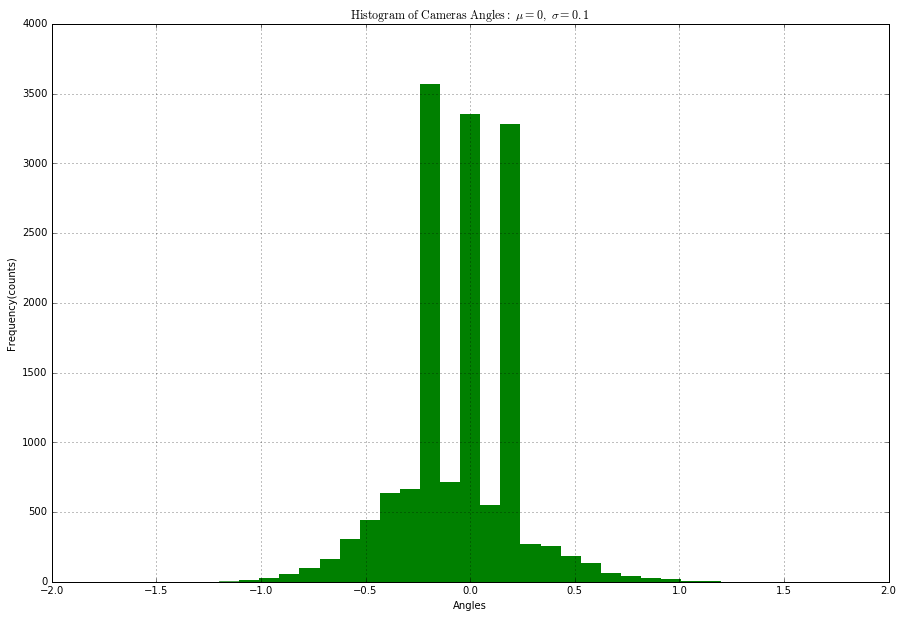

In [9]:
#After calling the load_images_and_measurements
car_images = []
steering_angle = []
car_images, steering_angle = load_images_and_measurements(new_lines)
fig, ax = plt.subplots(figsize=(15, 10))
plt.hist(list(steering_angle), 25, color='g', linewidth=0)    
plt.xlabel('Angles')
plt.ylabel('Frequency(counts)')
plt.title(r'$\mathrm{Histogram\ of\ Cameras\ Angles:}\ \mu=0, \ \sigma=0.1$')
plt.axis([-2, 2, 0, 4000])
plt.grid(True)
plt.show()
    

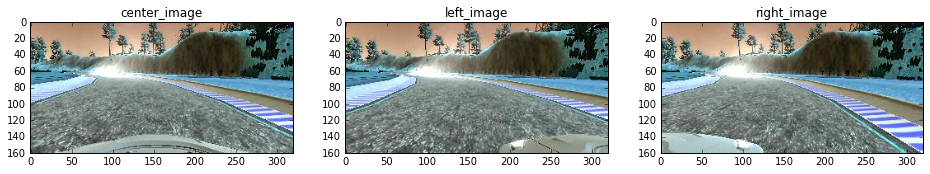

In [59]:
plt.figure (figsize=(16,8))
title = ['center_image', 'left_image', 'right_image']
for line in lines[:1]:
                 for i in range(3):
                        plt.subplot(1,3, i+1)
                        image = cv2.imread(line[i])
                        #img = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
                        plt.title(title[i])
                        plt.imshow(image)
                
                 plt.show()


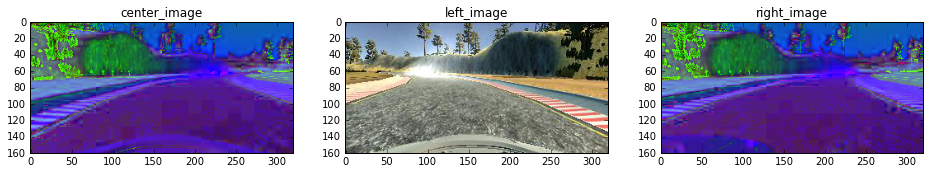

(160, 320, 3)


In [66]:
augment_image, augment_measurement = augment_data(car_images, steering_angle)

count = 0
plt.figure (figsize=(16,8))
title = ['center_image', 'left_image', 'right_image']
for carimg in augment_image[:3]:
            plt.subplot(1,3, count+1)
            image = Image.fromarray(carimg)
            plt.title(title[count])
            plt.imshow(image)
            count += 1
plt.show()
center_image = image

print(augment_image[0].shape)

In [ ]:

#let's shuffle before splitting
shuffle(lines)

#split the data 80% training 20% validation
train_data, validation_data = train_test_split(lines, test_size=0.2)

print('Starting Training Generator')
train_generator = data_generator(train_data, batch_size=PARAM['batchsize'])

print('Validation Generator')
validation_generator = data_generator(validation_data, batch_size=PARAM['batchsize'])



(160, 320, 3)


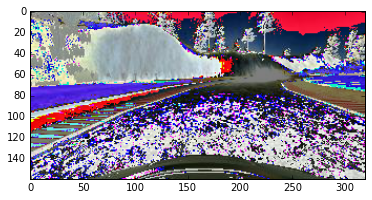

In [49]:
#Visualizing the Convolution Layer 
def visualize_image(model, img):
    img_batch = np.expand_dims(img, axis=0)
    conv_img2 = model.predict(img_batch)
    
    conv_img2 = np.squeeze(conv_img2, axis=0)
    #conv_img2 = conv_img2.reshape(160,320,1)
    print(conv_img2.shape)
    plt.imshow(conv_img2)
    
model = Sequential()
model.add(Lambda(lambda x: x/255.0 - 0.5, input_shape=(PARAM['input_height'], PARAM['input_width'], PARAM['input_channels'])))
visualize_image(model, augment_image[0])


(90, 320, 3)


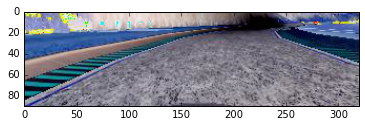

In [50]:
mymodel = Sequential()
mymodel.add(Cropping2D(cropping=((50,20), (0,0)), input_shape=(160,320,3)))
visualize_image(mymodel, augment_image[0])

(90, 320, 3)


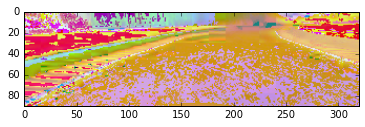

In [67]:
newmodel = Sequential()
newmodel.add(Cropping2D(cropping=((50,20), (0,0)), input_shape=(160,320,3)))
newmodel.add(Lambda(lambda x: x/255.0 - 0.5))
visualize_image(newmodel, augment_image[0])

In [ ]:
nvidia_model = nvidia_model(summary=True)                                                                                                                                                                   │
nvidia_model.compile(optimizer='adam', loss='mse')                                                                                                                                                          │
                                                                                                                                                                                                            │
lenet_model = LeNet_Model(summary=True)                                                                                                                                                                     │
lenet_model.compile(optimizer='adam', loss='mse')                                                                                                                                                           │
                                                                                                                                                                                                            │
train_steps_per_epoch = math.ceil((6*PARAM['batchsize']* (int(len(train_data))))/PARAM['batchsize'])                                                                                                        │
validation_steps_per_epoch = math.ceil((3*PARAM['batchsize']*(int(len(validation_data))))/PARAM['batchsize'])                                                                                               │
                                                                                                                                                                                                            │
print('train_steps_per_epoch {}'.format(train_steps_per_epoch))                                                                                                                                             │
print('validation_steps_per_epoch {}'.format(validation_steps_per_epoch))                                                                                                                                   │
                                                                                                                                                                                                            │
nvidia_model_history = nvidia_model.fit_generator(train_generator,                                                                                                                                          │
                    samples_per_epoch=train_steps_per_epoch,                                                                                                                                                │
                    validation_data = validation_generator,                                                                                                                                                 │
                    nb_val_samples = validation_steps_per_epoch,                                                                                                                                            │
                    nb_epoch=PARAM['epoch'],                                                                                                                                                                │
                    verbose=1)                                                                                                                                                                              │
                                                                                                                                                                                                            │
nvidia_model.save('nvidia_model.h5')  


│
                                                                                                                                                                                                            │
lenet_model_history = lenet_model.fit_generator(train_generator,                                                                                                                                            │
                samples_per_epoch=train_steps_per_epoch,                                                                                                                                                    │
                validation_data=validation_generator,                                                                                                                                                       │
                nb_val_samples = validation_steps_per_epoch,                                                                                                                                                │
                nb_epoch=PARAM['epoch'],                                                                                                                                                                    │
                verbose=1)                                                                                                                                                                                  │
                                                                                                                                                                                                            │
lenet_model.save('lenetmodel.h5')     